The project description and data are contained here: https://www.kaggle.com/c/kdd-cup-2014-predicting-excitement-at-donors-choose/data and here https://github.com/cc666/DSaPP_RA_Project.

### Summary

#### Exploratory analysis
1. The percentage of 'exciting' projects is 5.9%.
2. Notice that the min values for 'donation_to_project' and 'donation_optional_support' are both negative. This is problematic as values in both fields should be non-negative. This might be due to errors in data recording.

#### A Data Story
Are there common features shared by 'exciting' projects?
By exploring 'projects.csv', I found that 'exciting' projects are 70% more likely to come from chartered schools than non-chartered ones. Also, 'exciting' projects are more likely to require 'Books' and 'Other' as resources among all resource types. However, there do not seem to be clear distinctions in the distribution of 'exciting' projects within each of these features: primary focus areas, poverty level of schools, average number of students reached, types of corporate offers, public magnet or not. For example, for each primary focus area, the percentage of 'exciting' projects is centered around 5.7% which is close to the percentage of exciting projects in the whole population (i.e. 5.9%)

#### Questions for the Project Partner
1. I would like to confirm with my partner and find out why 'exciting' projects are 70% more likely to come from a chartered school than a non-chartered one. 

2. From the data given, the total number of students reached is calculated to be 64558408. This is about 20% of the 2016 figure of the total population in the US. This figure seems a little too big for me. I have already noticed some dubious figures like '999' or '999999' and I would like to work with my partner to cross check these figures, perhaps by using some other data sources or check with the schools where these figures belong to.

#### Models
To further investigate relations between various features in projects.csv and whether a project is 'exciting', I used three models: logistic regression, support vector machine and random forest. In all three models, I treated the problem as a binary classification problem (where '0' refers to a project being not 'exciting' and '1' 'exciting'). I think a model that shows high accuracy in predicting '1' in the test data would be particularly useful. For example, it could be used to help us assess whether a project is 'exciting' or not based on features collected in 'projects.csv'. This piece of infomation can be useful for businesses and individual donors who are thinking of financing projects. Furthermore, I have looked at coefficients (in logistic regression and SVM) and feature importance scores (in random forest) that evaluate how important each feature is for the target variable ('exciting' or not).  

From scores in the classification report, all three models gave similar performances. The accuracy in predicting '1' is around 60%. To improve the accuary, I would consider adding features from other data sources. For example, 'donations.csv' contains information on donated amount, donor's background etc which can be used in the predictive model. What could also be interesting but on a separate course is to understand the donation propensity of donors. To investigate this problem, we could analyse donors' messages from 'donation_message' in 'donations.csv'. We could for example use text summarisation methods to help us understand why donors donate and perhaps how that propensity differs between 'exciting' projects and non 'exciting' ones.        


> Below is the detailed analysis:

##### Data exploration 

Based on the 5 criteria given in the description, the number of 'exciting' projects should be equal to the number of projects satisfying all 5 criteria. The following codes show that it is indeed the case.   

In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
%matplotlib inline 

import operator
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection 
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import MinMaxScaler

scaling = MinMaxScaler()

#method for under-sampling 
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()


In [2]:
outcomes_raw = pd.read_csv("outcomes.csv")

In [3]:
outcomes_raw.describe()

,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
count,439487.00000,524928.000000,524928.000000
mean,52.92709,0.777339,4.361290
std,35.71410,2.227933,5.668748
min,0.00000,0.000000,0.000000
25%,25.00000,0.000000,1.000000
50%,50.00000,0.000000,3.000000
75%,83.00000,0.000000,5.000000
max,100.00000,151.000000,304.000000


In [4]:
outcomes_raw.head(10)

,projectid,is_exciting,at_least_1_teacher_referred_donor,fully_funded,at_least_1_green_donation,great_chat,three_or_more_non_teacher_referred_donors,one_non_teacher_referred_donor_giving_100_plus,donation_from_thoughtful_donor,great_messages_proportion,teacher_referred_count,non_teacher_referred_count
0,ffffc4f85b60efc5b52347df489d0238,f,NaN,f,NaN,f,NaN,NaN,NaN,NaN,NaN,NaN
1,ffffac55ee02a49d1abc87ba6fc61135,f,f,t,t,f,t,f,f,57.0,0.0,7.0
2,ffff97ed93720407d70a2787475932b0,f,f,t,t,t,t,t,f,100.0,0.0,3.0
3,ffff418bb42fad24347527ad96100f81,f,f,f,t,t,f,f,f,100.0,0.0,1.0
4,ffff2d9c769c8fb5335e949c615425eb,t,t,t,t,t,f,t,f,63.0,6.0,2.0
5,fffeebf4827d745aa36b17c2d38d1966,f,f,t,f,f,f,t,f,0.0,0.0,1.0
6,fffee68353ade53e7692b23098096683,f,f,f,f,f,f,f,f,0.0,0.0,2.0
7,fffec078a2249c2365f3086a6eac7e4a,f,f,t,f,f,f,t,f,NaN,0.0,1.0
8,fffeb149cd9b85d802b2500368fd605e,f,f,t,f,f,f,t,f,NaN,0.0,1.0
9,fffeaae9482c9b72cab5bbd3f061d362,f,f,f,f,f,f,f,f,0.0,0.0,1.0


In [5]:
count_exciting = outcomes_raw[outcomes_raw.is_exciting == 't']

In [6]:
count_exciting.count()[0]

36710

In [7]:
#compare with the total number of projects
count_total = outcomes_raw.projectid.count()
count_total

619326

In [8]:
#The percentage of 'exciting' projects:
print("The percentage of 'exciting' projects is {:.2f}%".format(100*count_exciting.count()[0]/count_total))

The percentage of 'exciting' projects is 5.93%


In [9]:
#now count the projects satisfying all 5 criteria
criteria = (outcomes_raw.fully_funded == 't') & (outcomes_raw.at_least_1_teacher_referred_donor == 't') & (outcomes_raw.great_chat == 't') & (outcomes_raw.at_least_1_green_donation == 't') & (~((outcomes_raw.three_or_more_non_teacher_referred_donors == 'f')&(outcomes_raw.one_non_teacher_referred_donor_giving_100_plus == 'f')&(outcomes_raw.donation_from_thoughtful_donor == 'f')))                                                           

In [10]:
criteria.value_counts()

False    582616
True      36710
dtype: int64

So this shows that the number of true counts (i.e. projects satisfying all the criteria) equals to the number of 'exciting' projects.

In [11]:
#load info about the donations to each project
donations_raw = pd.read_csv("donations.csv")

In [12]:
donations_raw.describe()

,donor_zip,donation_to_project,donation_optional_support,donation_total
count,873082.000000,1.953344e+06,1.953344e+06,1.953344e+06
mean,50621.290402,6.595058e+01,1.074128e+01,7.669065e+01
std,33300.650341,2.423894e+02,3.723160e+01,2.754747e+02
min,0.000000,-1.275000e+01,-2.250000e+00,-1.500000e+01
25%,20002.000000,1.000000e+01,1.500000e+00,1.000000e+01
50%,46540.000000,2.125000e+01,3.750000e+00,2.500000e+01
75%,89178.000000,5.000000e+01,7.500000e+00,5.616000e+01
max,99999.000000,1.472040e+05,2.199600e+04,1.692000e+05


Notice that the min values for 'donation_to_project' and 'donation_optional_support' are both negative. This is problematic as values in both fields should be non-negative. This might be due to errors in data recording.

In [13]:
donations_raw.head(10)

,donationid,projectid,donor_acctid,donor_city,donor_state,donor_zip,is_teacher_acct,donation_timestamp,donation_to_project,donation_optional_support,...,dollar_amount,donation_included_optional_support,payment_method,payment_included_acct_credit,payment_included_campaign_gift_card,payment_included_web_purchased_gift_card,payment_was_promo_matched,via_giving_page,for_honoree,donation_message
0,431d720bc3dfd75ae445a5eaa0b0638d,ffffac55ee02a49d1abc87ba6fc61135,22cbc920c9b5fa08dfb331422f5926b5,Peachtree City,GA,30269.0,f,2011-08-25 14:27:34.807,42.50,7.50,...,10_to_100,t,no_cash_received,f,t,f,f,f,f,I gave to this project because I support the e...
1,fcfedba1c8a0ba77d280cace80a909f6,ffffac55ee02a49d1abc87ba6fc61135,521f1830a77c9dbbf8119d99c6206a16,NaN,GA,NaN,f,2011-11-04 07:54:21.552,26.83,4.73,...,10_to_100,t,creditcard,f,t,f,f,f,f,I donated because I want to support kids in Ge...
2,3fa95d29986aa6f401c6719ced3a3ce7,ffffac55ee02a49d1abc87ba6fc61135,1e0a63fc8141c7ba26b8b44ca0871b90,Rockville,MD,20853.0,f,2011-11-02 22:53:53.019,55.35,0.00,...,10_to_100,f,no_cash_received,t,f,f,f,t,f,The Spark's 'pet' projects include those which...
3,020ad6bd5e88a35741d23b5e08f8b8e8,ffffac55ee02a49d1abc87ba6fc61135,1d4acb508df29d5f1cc6d382969576cb,Salem,IN,47167.0,f,2011-11-03 23:54:01.109,8.50,1.50,...,10_to_100,t,paypal,f,f,f,f,f,f,I gave to this project because Education is im...
4,4b44b03f304d6425ae94446686f93cd6,ffffac55ee02a49d1abc87ba6fc61135,59c3c3cfcccc53ae855f7eee911c478b,anonymous,NaN,0.0,f,2011-11-02 23:21:00.043,20.00,0.00,...,10_to_100,f,no_cash_received,f,f,t,f,t,f,I lent a paw to help the children in this clas...
5,9be4b22432cae4c9ad0a8f8b45e23549,ffffac55ee02a49d1abc87ba6fc61135,2215e4e3f54e8834284906fedca89383,NaN,NaN,NaN,f,2011-10-16 20:59:09.417,4.25,0.75,...,under_10,t,no_cash_received,f,t,f,f,f,f,I helped because I'm a strong believer in Spec...
6,d638145f90a23325b721813b2f8ee7c4,ffffac55ee02a49d1abc87ba6fc61135,f1b43a3b756a68b200df0301ff675d6c,NaN,GA,NaN,f,2011-08-31 08:13:55.15,50.00,0.00,...,10_to_100,f,creditcard,f,f,f,f,f,t,I helped because I'm a strong believer in Spec...
7,b39547f29dfc25fb13c6e9e8d940dc43,ffff97ed93720407d70a2787475932b0,12bc331b479e327d8be5dd475bb0d926,NaN,NY,NaN,f,2010-11-12 16:11:46.116,212.50,37.50,...,100_and_up,t,creditcard,f,f,f,f,t,f,I gave to this project because I am helping MC...
8,471e89e99b76bc0a84b4b7f2c1d85abe,ffff97ed93720407d70a2787475932b0,1fe8c1543e11969027ecea9d7ea3924e,NaN,NaN,NaN,f,2010-12-01 14:52:17.555,185.01,32.65,...,100_and_up,t,creditcard,f,f,f,f,t,f,Donation on behalf of Matt Carpenter because I...
9,87f432143e452c459dd13973c31acc3e,ffff97ed93720407d70a2787475932b0,6cec8667bfe0c941cbac6b5c22fee0ae,NaN,NaN,NaN,f,2010-11-23 09:09:10.16,21.25,3.75,...,10_to_100,t,creditcard,f,f,f,f,t,f,I gave to this project because I want to suppo...


In [14]:
donations_raw.donation_total.value_counts()

25.00      337647
10.00      238302
50.00      190251
15.00      165714
100.00     115974
5.00       106066
20.00      100870
1.00        80996
30.00       28855
3.00        26688
2.00        16978
75.00       16311
35.00       16037
40.00       13115
200.00      10644
150.00       7988
45.00        6912
60.00        5213
250.00       3601
6.00         2907
125.00       2832
500.00       2758
300.00       2744
70.00        2380
4.00         2366
12.00        2157
80.00        2143
18.00        2061
95.00        1826
2.50         1718
            ...  
552.71          1
1485.94         1
441.93          1
341.20          1
850.20          1
855.80          1
963.81          1
2048.75         1
238.17          1
1484.44         1
1829.41         1
633.13          1
440.82          1
1066.96         1
566.79          1
553.21          1
973.94          1
451.69          1
450.31          1
553.96          1
341.70          1
643.20          1
566.29          1
1068.46         1
1480.19   

In [15]:
#load info about the project text posted by the teachers
#essays_raw = pd.read_csv("essays.csv") #running this will throw the following error: "Error tokenizing data. C error: EOF inside string starting at line 55081"


In [16]:
#load the data about each project
projects_raw = pd.read_csv("projects.csv")

In [17]:
projects_raw.head(10)

,projectid,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,school_metro,...,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted
0,316ed8fb3b81402ff6ac8f721bb31192,42d43fa6f37314365d08692e08680973,c0e6ce89b244764085691a1b8e28cb81,6.362701e+10,36.576340,-119.608713,Selma,CA,93662.0,NaN,...,Books,highest poverty,Grades 6-8,30.0,555.81,653.89,32.0,f,f,2014-05-12
1,90de744e368a7e4883223ca49318ae30,864eb466462bf704bf7a16a585ef296a,d711e47810900c96f26a5d0be30c446d,4.837020e+11,32.911179,-96.723640,Dallas,TX,75243.0,urban,...,Books,highest poverty,Grades PreK-2,30.0,296.47,348.79,22.0,f,f,2014-05-12
2,32943bb1063267de6ed19fc0ceb4b9a7,37f85135259ece793213aca9d8765542,665c3613013ba0a66e3a2a26b89f1b68,4.103270e+11,45.166039,-122.414576,Colton,OR,97017.0,rural,...,Technology,high poverty,Grades PreK-2,30.0,430.89,506.93,17.0,f,f,2014-05-11
3,bb18f409abda2f264d5acda8cab577a9,2133fc46f951f1e7d60645b0f9e48a6c,4f12c3fa0c1cce823c7ba1df57e90ccb,3.600153e+11,40.641727,-73.965655,Brooklyn,NY,11226.0,urban,...,Books,highest poverty,Grades 3-5,30.0,576.07,677.73,12.0,f,f,2014-05-11
4,24761b686e18e5eace634607acbcc19f,867ff478a63f5457eaf41049536c47cd,10179fd362d7b8cf0e89baa1ca3025bb,6.227100e+10,34.043939,-118.288371,Los Angeles,CA,90006.0,urban,...,Other,highest poverty,Grades PreK-2,30.0,408.40,480.47,24.0,f,f,2014-05-11
5,eac7d156205f1333de3887d656f46611,ff064802c18e68db7ddb7ea0bf7732e8,929336e5a242d2e67f1a591196ba7701,4.018700e+10,33.298792,-111.827793,Chandler,AZ,85225.0,suburban,...,Technology,highest poverty,Grades 3-5,30.0,750.92,883.44,20.0,f,f,2014-05-11
6,5a3bfdf2e05781ccd0654dee0d51d1cd,085794a9e315b88cb7aec548831572f5,dc34b021fd177cfdb22f22055ca9d04f,1.006000e+10,32.838778,-85.517527,Lafayette,AL,36862.0,rural,...,Supplies,highest poverty,Grades PreK-2,30.0,2291.48,2695.86,320.0,f,f,2014-05-11
7,afda16eb54d8992db7bb42923b2a0c69,1d94a31c2dc38d51350eb26a4a2d892c,86fff7caa07e4f595a716d8a1960f09e,1.301290e+11,33.896013,-84.554213,Marietta,GA,30060.0,NaN,...,Books,highest poverty,Grades PreK-2,30.0,459.36,540.42,18.0,f,f,2014-05-11
8,2ab3efb23acc84017cd7896f62c2e889,5a497c425e05bb193564ef3ce2cbf3b6,ed170a147cd8ee2391b54b2f8b206160,2.612000e+11,42.422054,-83.209656,Detroit,MI,48235.0,urban,...,Technology,highest poverty,Grades PreK-2,30.0,325.39,382.81,25.0,f,f,2014-05-11
9,3118962680bb062323c3566197487315,eb0855cc6ea55d173ca8f8e4fd6a9e18,71b4dee33799c2111773bb4444766bf0,3.402640e+11,39.951767,-75.117188,Camden,NJ,8102.0,urban,...,Technology,highest poverty,Grades PreK-2,30.0,567.84,668.05,28.0,f,f,2014-05-11


In [18]:
summary_projects = projects_raw.describe()
summary_projects

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached
count,6.213620e+05,664098.000000,664098.000000,664094.000000,629016.000000,6.640980e+05,6.640980e+05,663952.000000
mean,2.608577e+11,37.240948,-93.344760,52926.452644,27.495822,5.420415e+02,6.447128e+02,97.233547
std,1.589754e+11,4.668155,17.761908,31193.738658,8.663046,1.267738e+04,1.545863e+04,2283.327661
min,1.000050e+10,18.249140,-176.634989,410.000000,9.000000,0.000000e+00,0.000000e+00,0.000000
25%,1.000230e+11,34.038082,-112.003213,27589.000000,17.000000,2.672000e+02,3.175000e+02,22.000000
50%,2.615730e+11,37.662476,-87.681219,50702.000000,30.000000,4.110000e+02,4.878400e+02,30.000000
75%,3.704720e+11,40.758827,-79.193091,85043.000000,35.000000,5.864900e+02,6.963875e+02,100.000000
max,6.100009e+11,67.258157,-66.628036,99950.000000,35.000000,1.025002e+07,1.250002e+07,999999.000000


In [19]:
#from this we see that the total number of students reached is this:
total_students_reached = summary_projects.loc['mean'].students_reached*summary_projects.loc['count'].students_reached
print(int(total_students_reached))

64558408


In [20]:
#load the data about resources
resources_raw = pd.read_csv("resources.csv")

In [21]:
resources_raw.head(10)

,resourceid,projectid,vendorid,vendor_name,project_resource_type,item_name,item_number,item_unit_price,item_quantity
0,8a1c1c45bc30d065061912fd9114fcf3,ffffc4f85b60efc5b52347df489d0238,430.0,Woodwind and Brasswind,Technology,iPod nano 4th Gen 8GB (Black),249995.001,149.00,4.0
1,015d2c4935c50427964a12dc3f584091,ffffac55ee02a49d1abc87ba6fc61135,82.0,Best Buy for Business,Technology,Sony bloggie MHS-FS1 - camcorder - internal fl...,BB11216668,148.00,1.0
2,26a02944b2f0c25f9abdeacca3ede3ee,ffff97ed93720407d70a2787475932b0,767.0,Lakeshore Learning Materials,Supplies,VX748 - Best-Buy Jumbo Crayons - 12-Color Box,VX748,69.95,1.0
3,7fef1f92cb4447d18d599f69ea27e833,ffff97ed93720407d70a2787475932b0,767.0,Lakeshore Learning Materials,Supplies,LA138 - Best-Buy Write & Wipe Broad-Tip Marker...,LA138,34.95,1.0
4,8dccf77df25ee615bb1a68b98ba9d861,ffff97ed93720407d70a2787475932b0,767.0,Lakeshore Learning Materials,Supplies,BJ7471 - 1 1/2&#34; Ruled Chart Tablet,BJ7471,10.95,4.0
5,76ad6546da5113f03162c3c38da3bd21,ffff97ed93720407d70a2787475932b0,767.0,Lakeshore Learning Materials,Supplies,NF9763 - White Sentence Strips,NF9763,3.99,2.0
6,f2293c48469eeedd11820bf479a37f4b,ffff97ed93720407d70a2787475932b0,767.0,Lakeshore Learning Materials,Supplies,HU18 - Electric Pencil Sharpener,HU18,44.95,1.0
7,8b0a477c471f955076c997b459ed672f,ffff97ed93720407d70a2787475932b0,767.0,Lakeshore Learning Materials,Supplies,GG297 - Behavior Management Pocket Chart,GG297,19.95,1.0
8,aaabc2bfec809a6ee988f83c54f1af4d,ffff97ed93720407d70a2787475932b0,767.0,Lakeshore Learning Materials,Supplies,LC1561 - Sentence Strip Storage Box,LC1561,6.95,1.0
9,dc122690989bb55bc5ccdb88fd6ef15b,ffff97ed93720407d70a2787475932b0,767.0,Lakeshore Learning Materials,Supplies,TT991 - Lakeshore Safety Name Tags - Set of 20,TT991,29.95,1.0


##### Now I will consider if there are common features shared by 'exciting' projects. 

In [22]:
#Now I will join outcomes_raw ('is_exciting') with projects_raw, resources_raw and donations_raw separately. I will leave out essays_raw due to file reading issues in pandas.
outcome_table = outcomes_raw[['projectid','is_exciting']]

In [23]:
outcome_table.head(10)

,projectid,is_exciting
0,ffffc4f85b60efc5b52347df489d0238,f
1,ffffac55ee02a49d1abc87ba6fc61135,f
2,ffff97ed93720407d70a2787475932b0,f
3,ffff418bb42fad24347527ad96100f81,f
4,ffff2d9c769c8fb5335e949c615425eb,t
5,fffeebf4827d745aa36b17c2d38d1966,f
6,fffee68353ade53e7692b23098096683,f
7,fffec078a2249c2365f3086a6eac7e4a,f
8,fffeb149cd9b85d802b2500368fd605e,f
9,fffeaae9482c9b72cab5bbd3f061d362,f


In [24]:
projects_outcome = outcome_table.join(projects_raw.set_index('projectid'),on='projectid')

In [25]:
projects_outcome.head(10)

,projectid,is_exciting,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,...,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted
0,ffffc4f85b60efc5b52347df489d0238,f,c24011b20fc161ed02248e85beb59a90,301c9bf0a45d159d162b65a93fddd74e,4.502130e+11,34.361999,-80.063582,Florence,SC,29501.0,...,Technology,high poverty,Grades 3-5,9.0,703.34,857.73,90.0,f,f,2009-10-11
1,ffffac55ee02a49d1abc87ba6fc61135,f,947066d0af47e0566f334566553dd6a6,103ed937d8d84fdffe8b87a4811f00bf,1.301230e+11,33.514296,-84.345336,Jonesboro,GA,30236.0,...,Technology,highest poverty,Grades PreK-2,35.0,207.43,244.04,8.0,f,f,2011-06-11
2,ffff97ed93720407d70a2787475932b0,f,462270f5d5c212162fcab11afa2623cb,9943fdb43ab5f2b53f27e961caf9e90a,3.600153e+11,40.631962,-73.923897,Brooklyn,NY,11234.0,...,Supplies,highest poverty,Grades PreK-2,35.0,440.01,517.66,25.0,t,f,2010-09-11
3,ffff418bb42fad24347527ad96100f81,f,e885fb002a1d0d39aaed9d21a7683549,6c6ea0558a03d113856e828ca7706092,4.827030e+11,30.389966,-97.843495,Austin,TX,78730.0,...,Supplies,low poverty,Grades 3-5,17.0,798.85,974.21,20.0,f,f,2009-04-03
4,ffff2d9c769c8fb5335e949c615425eb,t,485784e52a4c85ea6783285d09d8aea4,f8e49225a821cc04e1176303e55d89ec,1.602640e+11,42.820593,-112.409161,Pocatello,ID,83204.0,...,Technology,high poverty,Grades 3-5,30.0,579.74,682.05,25.0,f,f,2013-03-03
5,fffeebf4827d745aa36b17c2d38d1966,f,96c1a33b4f2b832595c3c6a01bc24c05,7bb6b1924a7bd181ab5568b062260966,6.346201e+10,38.654224,-121.308122,Fair Oaks,CA,95628.0,...,Other,highest poverty,Grades 6-8,30.0,797.30,938.00,11.0,f,f,2012-12-01
6,fffee68353ade53e7692b23098096683,f,dddd29e34a0e4d889e65ccaa6efc44cf,c54b1598cbf381fd436e1f2dc675d9e0,4.501920e+11,34.413800,-79.362942,Dillon,SC,29536.0,...,Books,highest poverty,Grades PreK-2,35.0,1033.32,1215.67,24.0,f,f,2010-11-15
7,fffec078a2249c2365f3086a6eac7e4a,f,b70b3bcacd73905c88028ba115740ddf,7a446d5eafe11837c5d18ccdc73a1afc,3.627810e+11,41.148952,-74.075874,Wesley Hills,NY,10952.0,...,Technology,highest poverty,Grades PreK-2,NaN,914.30,1115.00,20.0,f,f,2006-11-22
8,fffeb149cd9b85d802b2500368fd605e,f,f112713d3b77fc8fea33c03c6d5f7231,d124611f60c45c575f039388e767f01e,4.022770e+11,35.400153,-97.539192,Oklahoma City,OK,73159.0,...,Supplies,highest poverty,Grades 3-5,17.0,748.00,912.20,15.0,f,f,2009-05-12
9,fffeaae9482c9b72cab5bbd3f061d362,f,f4623252bca640eaa810eb1feda47fe5,58cf2aa703a386b48409b450573a0a0c,4.033480e+11,35.513864,-97.735051,Yukon,OK,73099.0,...,Books,high poverty,Grades PreK-2,35.0,467.06,549.48,88.0,f,f,2011-07-26


In [26]:
projects_outcome.describe()

,school_ncesid,school_latitude,school_longitude,school_zip,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached
count,5.804780e+05,619326.000000,619326.000000,619322.000000,584244.000000,6.193260e+05,6.193260e+05,619182.000000
mean,2.613607e+11,37.231092,-93.352804,52973.842337,27.303921,5.359818e+02,6.380910e+02,97.439624
std,1.589146e+11,4.647585,17.754605,31206.795217,8.960030,1.312596e+04,1.600576e+04,2364.069969
min,1.000050e+10,18.249140,-176.634989,410.000000,9.000000,0.000000e+00,0.000000e+00,0.000000
25%,1.000230e+11,34.039135,-112.012257,27574.000000,17.000000,2.670000e+02,3.175000e+02,22.000000
50%,2.619830e+11,37.651288,-87.683411,52302.000000,30.000000,4.106600e+02,4.878000e+02,30.000000
75%,3.704720e+11,40.758552,-79.142391,85122.000000,35.000000,5.803675e+02,6.900175e+02,100.000000
max,6.100009e+11,67.258157,-66.628036,99950.000000,35.000000,1.025002e+07,1.250002e+07,999999.000000


From the table, notice that the max number of students reached is 999999, which seems to be an error. 

In [27]:
projects_raw.shape, outcomes_raw.shape

((664098, 35), (619326, 12))

In [28]:
projects_outcome.shape

(619326, 36)

Now what is the percentage of 'exciting' projects in each primary focus area?

In [29]:
total_counts = projects_outcome.primary_focus_area.value_counts()

exciting_counts = projects_outcome.primary_focus_area[projects_outcome.is_exciting == 't'].value_counts() 

areas = total_counts.keys()

exciting_proj_per = [exciting_counts[area]/total_counts[area] for area in areas]


exciting_proj_per_areas = pd.Series(data=exciting_proj_per,index=areas)
exciting_proj_per_areas

Literacy & Language    0.063473
Math & Science         0.054755
Music & The Arts       0.061910
Applied Learning       0.046264
Special Needs          0.065443
History & Civics       0.054242
Health & Sports        0.051975
dtype: float64

In [30]:
np.mean(exciting_proj_per_areas.values)

0.0568661714917768

The values of the above numbers center around 0.057 and does not seem to show clear distinctions across primary focus areas. 

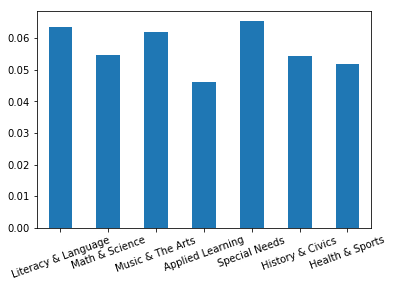

In [31]:
#plot a bar chart
exciting_proj_per_areas.plot(kind='bar',rot=20)

How about poverty level of schools?

In [32]:
total_counts = projects_outcome.poverty_level.value_counts()

exciting_counts = projects_outcome.poverty_level[projects_outcome.is_exciting == 't'].value_counts() 

school_poverty_level = total_counts.keys()

exciting_proj_pcg = [exciting_counts[i]/total_counts[i] for i in school_poverty_level]

exciting_proj_pcg_povlevel = pd.Series(data=exciting_proj_pcg,index=school_poverty_level)
exciting_proj_pcg_povlevel

highest poverty     0.060004
high poverty        0.055447
moderate poverty    0.063045
low poverty         0.062025
dtype: float64

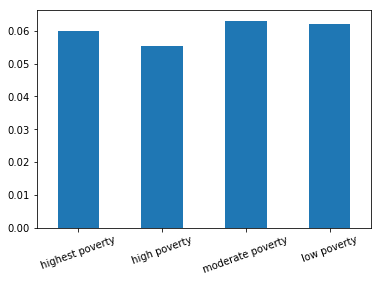

In [33]:
#plot a bar chart
exciting_proj_pcg_povlevel.plot(kind='bar',rot=20)

How do 'students_reached' differ betweem the two types of projects? I will compare the average number of students reached. 

In [34]:
stu_reached_exc = projects_outcome.students_reached[projects_outcome.is_exciting == 't']
stu_reached_exc.describe()

count    36700.000000
mean        88.357956
std        138.895246
min          1.000000
25%         23.000000
50%         31.000000
75%        100.000000
max        999.000000
Name: students_reached, dtype: float64

In [35]:
stu_reached_oth = projects_outcome.students_reached[projects_outcome.is_exciting == 'f']
stu_reached_oth.describe()

count    582482.000000
mean         98.011825
std        2437.157643
min           0.000000
25%          22.000000
50%          30.000000
75%         100.000000
max      999999.000000
Name: students_reached, dtype: float64

The above shows that the average number of students reached by 'exciting' projects (i.e. 88) is smaller than that for other projects (i.e. 98), which is a bit surprising.

In [36]:
#pick out records whose student_reached is 999
temp = projects_outcome[projects_outcome.students_reached == 999]

In [37]:
temp.shape

(2446, 36)

In [38]:
temp.head(10)

,projectid,is_exciting,teacher_acctid,schoolid,school_ncesid,school_latitude,school_longitude,school_city,school_state,school_zip,...,resource_type,poverty_level,grade_level,fulfillment_labor_materials,total_price_excluding_optional_support,total_price_including_optional_support,students_reached,eligible_double_your_impact_match,eligible_almost_home_match,date_posted
425,ffd6bc02cfb6403eae39b7cf8eec1bf7,f,8406afb04c5e1309d880d336c4d4224c,fc14d63c41878649255425dfde6360cd,6.167400e+10,37.642609,-122.066188,Hayward,CA,94544.0,...,Supplies,highest poverty,Grades 9-12,35.0,507.83,597.45,999.0,f,t,2011-03-18
510,ffcd5668a20e22f2205dd8119e6b585f,f,9b1853c46ed8fe4938a3f7490440e426,bd6f44cf6cac99d07ad0b74ee1ea1eea,6.078000e+10,37.698202,-122.081139,Castro Valley,CA,94546.0,...,Supplies,high poverty,Grades 3-5,9.0,646.33,788.21,999.0,f,f,2010-05-06
858,ffaa49fa2583570b8b85a92ea2ec2be9,f,95d0cd45ac799f5ef5098e89820d1b47,ce7b330c6cda8a68c613dfbec416986f,1.200420e+11,27.223603,-81.841706,Arcadia,FL,34266.0,...,Technology,highest poverty,Grades 9-12,9.0,751.76,916.78,999.0,f,t,2010-05-13
871,ffa9147e18b5e223b5fa48b900a711c1,t,289a1cd18f2d5c3568e9415571ace16e,3ccd120ab666bdfa0629bc04de2b47e1,NaN,33.532098,-112.315334,Glendale,AZ,85307.0,...,Supplies,high poverty,Grades 3-5,35.0,506.35,595.71,999.0,t,f,2010-10-16
905,ffa5bdcd2e59b62fe74a50ac9bf0ef03,f,8a81d5436ba6c3c8572cf9c62fd2a6f2,6d266b9971de71e0928134874e0f9403,NaN,37.732399,-122.457611,San Francisco,CA,94127.0,...,Technology,high poverty,Grades 9-12,35.0,295.95,348.18,999.0,t,f,2012-01-22
1148,ff8e29ea427bd2bd3e9ee7faa1b5c2a0,f,8a81d5436ba6c3c8572cf9c62fd2a6f2,6d266b9971de71e0928134874e0f9403,NaN,37.732399,-122.457611,San Francisco,CA,94127.0,...,Technology,high poverty,Grades 9-12,35.0,303.86,357.48,999.0,t,f,2012-02-12
1437,ff7069927ab1612020a7969733f85ba1,f,122b754014d1450a1fe7b0c884ebc221,8f4fe41652668abd0c7e07741fbb98a4,6.028500e+10,38.005107,-121.815397,Antioch,CA,94509.0,...,Books,high poverty,Grades 9-12,30.0,892.66,1050.19,999.0,f,f,2013-09-16
1689,ff55ba30da1bac877121cdcd966b8155,f,67d3e2122a0813a14adfe15cbf4f5ddc,2725845c215e82e2d10d9ec063fb1fab,3.608880e+11,40.764151,-73.336298,Deer Park,NY,11729.0,...,Technology,moderate poverty,Grades 9-12,30.0,2085.00,2452.94,999.0,f,t,2013-11-13
1797,ff4bb556f08a7d117ed64e943d8dc2c7,f,9b04d1023923757a451f5662b8682597,5166f316af1d18ebff5ec25085c35b8e,5.308250e+11,47.651943,-117.420769,Spokane,WA,99204.0,...,Supplies,high poverty,Grades 9-12,30.0,158.65,186.65,999.0,f,f,2013-02-19
2050,ff33269efa1d1dde2d2adc3872a8fc96,f,8b266aa3aa9dc79b3e731bc773b64c05,470c0cb2d89752c6ada1ae064a2ee355,4.816110e+11,29.858117,-95.708591,Katy,TX,77449.0,...,Technology,highest poverty,Grades 3-5,30.0,803.39,945.16,999.0,t,f,2013-10-27


The numbers of students reached seem to be problematic (e.g. values like '999' and '999999'). One possibility is that they are rough estimates. 

How do resource types distribute among 'exciting' and other projects?

In [39]:
total_counts = projects_outcome.resource_type.value_counts()

exciting_counts = projects_outcome.resource_type[projects_outcome.is_exciting == 't'].value_counts() 

resourceTypes = total_counts.keys()

exciting_proj_pcg = [exciting_counts[i]/total_counts[i] for i in resourceTypes]

exciting_proj_pcg_resTypes = pd.Series(data=exciting_proj_pcg,index=resourceTypes)
exciting_proj_pcg_resTypes

Supplies      0.057137
Technology    0.053762
Books         0.067932
Other         0.066448
Trips         0.046341
Visitors      0.051648
dtype: float64

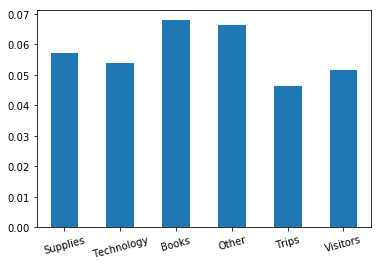

In [40]:
#bar plot
exciting_proj_pcg_resTypes.plot(kind='bar',rot=15)

Observe that 'exciting' projects are more likely to require 'books' as resources than other resource types. 

Distribution of corporate offers over two types of projects. 

In [41]:
#50%-off offer
total_counts = projects_outcome.eligible_double_your_impact_match.value_counts()

exciting_counts = projects_outcome.eligible_double_your_impact_match[projects_outcome.is_exciting == 't'].value_counts() 

eligibility = total_counts.keys()

exciting_proj_pcg = [exciting_counts[i]/total_counts[i] for i in eligibility]

exciting_proj_pcg_eli = pd.Series(data=exciting_proj_pcg,index=['uneligible','eligible'])
exciting_proj_pcg_eli

uneligible    0.060323
eligible      0.056531
dtype: float64

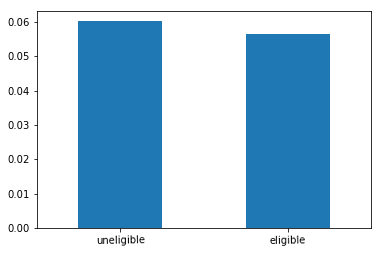

In [42]:
#bar plot
exciting_proj_pcg_eli.plot(kind='bar',rot=1)

In [43]:
#$100 boost offer
total_counts = projects_outcome.eligible_almost_home_match.value_counts()

exciting_counts = projects_outcome.eligible_almost_home_match[projects_outcome.is_exciting == 't'].value_counts() 

eligibility = total_counts.keys()

exciting_proj_pcg = [exciting_counts[i]/total_counts[i] for i in eligibility]

exciting_proj_pcg_b_eli = pd.Series(data=exciting_proj_pcg,index = ['uneligible','eligible'])
exciting_proj_pcg_b_eli

uneligible    0.059548
eligible      0.055025
dtype: float64

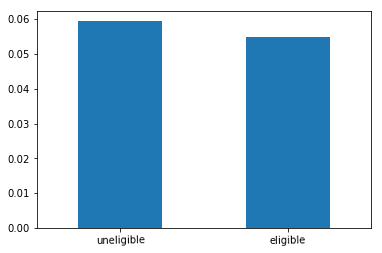

In [44]:
exciting_proj_pcg_b_eli.plot(kind='bar',rot=1)

How about whether it is a public charter school or not?

In [45]:
total_counts = projects_outcome.school_charter.value_counts()

exciting_counts = projects_outcome.school_charter[projects_outcome.is_exciting == 't'].value_counts() 

charter_or_not = total_counts.keys()

exciting_proj_pcg = [exciting_counts[i]/total_counts[i] for i in charter_or_not]

exciting_proj_pcg_charted = pd.Series(data=exciting_proj_pcg,index=['not chartered','chartered'])
exciting_proj_pcg_charted

not chartered    0.055900
chartered        0.095047
dtype: float64

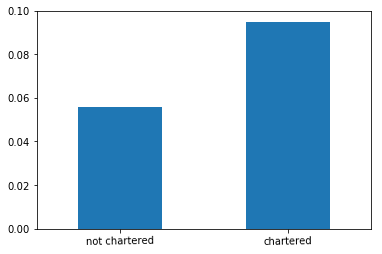

In [46]:
exciting_proj_pcg_charted.plot(kind='bar',rot=1)

In [47]:
(0.095 - 0.056)/0.056

0.6964285714285714

#### This shows that 'exciting' projects are 70% more likely to come from a chartered school than a non-chartered one. 

In [48]:
#whether a public magnet school or not
total_counts = projects_outcome.school_magnet.value_counts()

exciting_counts = projects_outcome.school_magnet[projects_outcome.is_exciting == 't'].value_counts() 

magnet_or_not = total_counts.keys()

exciting_proj_pcg = [exciting_counts[i]/total_counts[i] for i in magnet_or_not]

exciting_proj_pcg_mag = pd.Series(data=exciting_proj_pcg,index=['not magnet','magnet'])
exciting_proj_pcg_mag

not magnet    0.059448
magnet        0.057609
dtype: float64

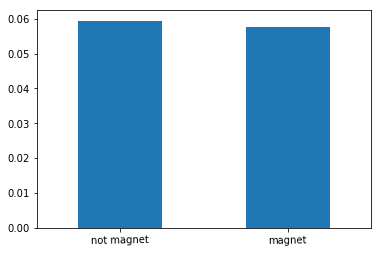

In [49]:
exciting_proj_pcg_mag.plot(kind='bar',rot=1)

#### Modelling

I would like to find out if there is a noticeable correlation between a project being 'exciting' and its features in 'projects.csv'. Such correlation, if exists, can be used to predict whether a project is 'exciting'.  

In [50]:
unselected_features = ['projectid','date_posted','teacher_prefix','teacher_acctid','schoolid','school_ncesid',\
                      'school_latitude','school_longitude','school_city','school_state','school_zip',\
                      'school_metro','school_district','school_county','date_posted']
projects_outcome_dropna = projects_outcome.dropna()
X = projects_outcome_dropna.drop(unselected_features,axis=1)
for feature in X.columns:
    X.loc[:,feature] = label_encoder.fit_transform(X[feature])

Z = X.copy()


Now I want to vectorise categorical features having more than 2 categories.

In [51]:
#remove two categrical features which contain too many categories
Z.drop(['primary_focus_subject','secondary_focus_subject'],axis=1,inplace=True)


In [52]:
#one-hot encode the following list of features
features_to_be_encoded = ['primary_focus_area','secondary_focus_area','resource_type','poverty_level',\
                         'grade_level','fulfillment_labor_materials']

In [53]:
for feature in features_to_be_encoded:
    Z = Z.join(pd.get_dummies(projects_outcome_dropna.loc[:,feature],prefix=feature))
    Z.drop(feature,axis=1,inplace=True)


In [54]:
Z.describe()

,is_exciting,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,total_price_excluding_optional_support,...,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,fulfillment_labor_materials_9.0,fulfillment_labor_materials_17.0,fulfillment_labor_materials_30.0,fulfillment_labor_materials_35.0
count,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,...,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000
mean,0.058664,0.051695,0.106963,0.053587,0.016108,0.002869,0.003989,0.046574,0.018906,31517.313933,...,0.022739,0.139917,0.321707,0.164584,0.133841,0.379868,0.121193,0.190344,0.322545,0.365918
std,0.234995,0.221410,0.309067,0.225202,0.125890,0.053485,0.063030,0.210725,0.136193,20169.929334,...,0.149070,0.346901,0.467132,0.370805,0.340482,0.485355,0.326352,0.392573,0.467451,0.481687
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15320.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29310.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,44674.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,81713.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Now remains to normalise columns whose values are beyond [0,1]

In [55]:
features_to_normalise = ['total_price_excluding_optional_support','total_price_including_optional_support',\
                         'students_reached']
Z_normalised = Z.copy()
Z_normalised.loc[:,features_to_normalise] = scaling.fit_transform(Z[features_to_normalise])
Z_normalised.describe()

,is_exciting,school_charter,school_magnet,school_year_round,school_nlns,school_kipp,school_charter_ready_promise,teacher_teach_for_america,teacher_ny_teaching_fellow,total_price_excluding_optional_support,...,poverty_level_low poverty,poverty_level_moderate poverty,grade_level_Grades 3-5,grade_level_Grades 6-8,grade_level_Grades 9-12,grade_level_Grades PreK-2,fulfillment_labor_materials_9.0,fulfillment_labor_materials_17.0,fulfillment_labor_materials_30.0,fulfillment_labor_materials_35.0
count,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,...,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000,340210.000000
mean,0.058664,0.051695,0.106963,0.053587,0.016108,0.002869,0.003989,0.046574,0.018906,0.385707,...,0.022739,0.139917,0.321707,0.164584,0.133841,0.379868,0.121193,0.190344,0.322545,0.365918
std,0.234995,0.221410,0.309067,0.225202,0.125890,0.053485,0.063030,0.210725,0.136193,0.246839,...,0.149070,0.346901,0.467132,0.370805,0.340482,0.485355,0.326352,0.392573,0.467451,0.481687
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.187485,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.358694,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.546718,...,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


##### Logistic regression

In [56]:
W = Z_normalised.drop('is_exciting',axis=1)
y = Z_normalised.loc[:,'is_exciting']

#W.shape,y.shape

W_res,y_res = rus.fit_sample(W,y) #perform under-sampling

W_res_df = pd.DataFrame(W_res,columns=W.columns) 
#split the data into training and testing sets
W_train, W_test, y_train, y_test = model_selection.train_test_split(W_res_df,y_res,test_size=0.2) 
#apply the logistic regression model
log_model = LogisticRegression()
log_model.fit(W_train,y_train)
y_pred = log_model.predict(W_test)

print(classification_report(y_test,y_pred))

             precision    recall  f1-score   support

          0       0.84      0.42      0.56      3945
          1       0.62      0.92      0.74      4039

avg / total       0.73      0.67      0.65      7984



In [57]:
#investigate training error
y_pred_train = log_model.predict(W_train)
print(classification_report(y_train,y_pred_train))

             precision    recall  f1-score   support

          0       0.84      0.40      0.54     16013
          1       0.61      0.92      0.73     15919

avg / total       0.72      0.66      0.64     31932



The training error is similar to the testing error. It is unlikely that the model is overfitting the data. 

In [58]:
#output features with their corresponding coefficients, in ascending order
d = {}
for item, value in zip(list(W_train.columns),log_model.coef_[0]):
    d[item] = value

    
coef_df = pd.DataFrame.from_dict(d,orient='index')

coef_df.rename(columns={0:'value'},inplace=True)

coef_df.sort_values(['value'],ascending=False)

,value
fulfillment_labor_materials_30.0,2.798818
fulfillment_labor_materials_35.0,2.700624
total_price_including_optional_support,1.728121
teacher_teach_for_america,0.783872
school_charter,0.503928
teacher_ny_teaching_fellow,0.450065
school_nlns,0.309821
resource_type_Visitors,0.163826
resource_type_Trips,0.153037
school_magnet,0.022955


##### Support vector machine

In [59]:
#linear SVM
sv_clf = LinearSVC()

sv_clf.fit(W_train,y_train)

y_pred = sv_clf.predict(W_test)
print(classification_report(y_true=y_test,y_pred=y_pred))

             precision    recall  f1-score   support

          0       0.86      0.41      0.56      3945
          1       0.62      0.93      0.74      4039

avg / total       0.74      0.68      0.65      7984



In [60]:
#output features with their corresponding coefficients
d = {}
for item, value in zip(list(W_train.columns),list(sv_clf.coef_[0])):
    d[item] = value

    
coef_df = pd.DataFrame.from_dict(d,orient='index')

coef_df.rename(columns={0:'value'},inplace=True)

coef_df.sort_values(['value'],ascending=False)

,value
total_price_including_optional_support,5.341071
fulfillment_labor_materials_30.0,0.766178
fulfillment_labor_materials_35.0,0.720762
teacher_teach_for_america,0.313297
school_charter,0.218196
teacher_ny_teaching_fellow,0.196982
school_nlns,0.129057
resource_type_Trips,0.115080
resource_type_Visitors,0.099462
primary_focus_area_Music & The Arts,0.027634


##### Random forest

In [61]:
rf_clf = RandomForestClassifier(max_depth=3)

rf_clf.fit(W_train,y_train)

y_pred = rf_clf.predict(W_test)

print(classification_report(y_true=y_test,y_pred=y_pred))

             precision    recall  f1-score   support

          0       0.86      0.40      0.55      3945
          1       0.62      0.94      0.74      4039

avg / total       0.74      0.67      0.65      7984



In [62]:
#output features with their corresponding feature importance scores
d = {}
for item, value in zip(list(W_train.columns),list(rf_clf.feature_importances_)):
    d[item] = value

    
coef_df = pd.DataFrame.from_dict(d,orient='index')

coef_df.rename(columns={0:'value'},inplace=True)

coef_df.sort_values(['value'],ascending=False)
   

,value
fulfillment_labor_materials_17.0,0.225894
fulfillment_labor_materials_9.0,0.203839
fulfillment_labor_materials_35.0,0.107246
total_price_excluding_optional_support,0.106964
fulfillment_labor_materials_30.0,0.089196
teacher_teach_for_america,0.079054
total_price_including_optional_support,0.066035
school_charter,0.050132
resource_type_Technology,0.020210
eligible_almost_home_match,0.018402
